# Import and update Grid electricity mix by country Automatically
This journal points at Ember grid electricity data, pulls the file, parses it for the countrywise grid mix percentages. These are then saved into the carbon baseline_countrygridmix.csv and used for the carbon calculations in PV ICE.

In [1]:
import numpy as np
import pandas as pd
import os,sys
from pathlib import Path
import matplotlib.pyplot as plt
from urllib.request import urlretrieve
#import PV_ICE
cwd = os.getcwd() #grabs current working directory

In [2]:
supportMatfolder = str(Path().resolve().parent.parent / 'PV_ICE' / 'baselines' / 'SupportingMaterial')
baselinesFolder = str(Path().resolve().parent.parent / 'PV_ICE' / 'baselines')
cwd

'C:\\Users\\hmirletz\\Documents\\GitHub\\PV_ICE\\docs\\baseline development documentation'

In [3]:
#print("Working on a ", platform.system(), platform.release())
print("Python version ", sys.version)
print("Pandas version ", pd.__version__)
print("pyplot ", plt.matplotlib.__version__)
#print("PV_ICE version ", PV_ICE.__version__)

Python version  3.11.5 | packaged by Anaconda, Inc. | (main, Sep 11 2023, 13:26:23) [MSC v.1916 64 bit (AMD64)]
Pandas version  2.0.3
pyplot  3.7.2


In [4]:
url = 'https://ember-climate.org/app/uploads/2022/07/yearly_full_release_long_format.csv'

In [5]:
storage_options = {'User-Agent': 'Mozilla/5.0'}
emberdata_raw = pd.read_csv(url, storage_options=storage_options)

emberdata_raw.head()

,Area,Country code,Year,Area type,Continent,Ember region,EU,OECD,G20,G7,ASEAN,Category,Subcategory,Variable,Unit,Value,YoY absolute change,YoY % change
0,Afghanistan,AFG,2000,Country,Asia,Asia,0.0,0.0,0.0,0.0,0.0,Capacity,Aggregate fuel,Clean,GW,0.19,NaN,NaN
1,Afghanistan,AFG,2000,Country,Asia,Asia,0.0,0.0,0.0,0.0,0.0,Capacity,Aggregate fuel,Fossil,GW,0.03,NaN,NaN
2,Afghanistan,AFG,2000,Country,Asia,Asia,0.0,0.0,0.0,0.0,0.0,Capacity,Aggregate fuel,Gas and Other Fossil,GW,0.03,NaN,NaN
3,Afghanistan,AFG,2000,Country,Asia,Asia,0.0,0.0,0.0,0.0,0.0,Capacity,Aggregate fuel,"Hydro, Bioenergy and Other Renewables",GW,0.19,NaN,NaN
4,Afghanistan,AFG,2000,Country,Asia,Asia,0.0,0.0,0.0,0.0,0.0,Capacity,Aggregate fuel,Renewables,GW,0.19,NaN,NaN


In [6]:
#down select for only columsn of interest
emberdata = emberdata_raw.filter(items=['Area','Year','Variable','Unit','Value'])

#downselect for only variables of interest (that don't overlap/double count)
Variables = ['Bioenergy','Coal','Gas','Hydro','Nuclear','Other Fossil','Solar','Wind']
emberdata_vars = emberdata.loc[emberdata['Variable'].isin(Variables)]

#select only the % of energy generation, % only used for energy generation (I checked)
#emberdata_vars['Unit'].unique()
Units = ['%']
emberdata_vars_perc = emberdata_vars.loc[emberdata_vars['Unit'].isin(Units)]
emberdata_vars_perc.reset_index(drop=True, inplace=True)
emberdata_vars_perc

,Area,Year,Variable,Unit,Value
0,Afghanistan,2000,Bioenergy,%,0.00
1,Afghanistan,2000,Coal,%,0.00
2,Afghanistan,2000,Gas,%,0.00
3,Afghanistan,2000,Hydro,%,64.58
4,Afghanistan,2000,Nuclear,%,0.00
...,...,...,...,...,...
41708,Zimbabwe,2022,Hydro,%,65.85
41709,Zimbabwe,2022,Nuclear,%,0.00
41710,Zimbabwe,2022,Other Fossil,%,0.00
41711,Zimbabwe,2022,Solar,%,0.34


In [7]:
emberdata_vars_perc['Area'].unique()

array(['Afghanistan', 'Africa', 'Albania', 'Algeria', 'American Samoa',
       'Angola', 'Antigua and Barbuda', 'Argentina', 'Armenia', 'Aruba',
       'ASEAN', 'Asia', 'Australia', 'Austria', 'Azerbaijan',
       'Bahamas (the)', 'Bahrain', 'Bangladesh', 'Barbados', 'Belarus',
       'Belgium', 'Belize', 'Benin', 'Bermuda', 'Bhutan', 'Bolivia',
       'Bosnia Herzegovina', 'Botswana', 'Brazil', 'Brunei Darussalam',
       'Bulgaria', 'Burkina Faso', 'Burundi', 'Cabo Verde', 'Cambodia',
       'Cameroon', 'Canada', 'Cayman Islands (the)',
       'Central African Republic (the)', 'Chad', 'Chile', 'China',
       'Colombia', 'Comoros (the)',
       'Congo (the Democratic Republic of the)', 'Congo (the)',
       'Cook Islands (the)', 'Costa Rica', "Cote d'Ivoire", 'Croatia',
       'Cuba', 'Cyprus', 'Czechia', 'Denmark', 'Djibouti', 'Dominica',
       'Dominican Republic (the)', 'Ecuador', 'Egypt', 'El Salvador',
       'Equatorial Guinea', 'Eritrea', 'Estonia', 'Eswatini', 'Ethiopia',
  

In [9]:
#munge the Area strings into a more usable format (this takes a while!)
import re
def remove_substrings_regex(text, substrings):
    pattern = '|'.join(map(re.escape, substrings))
    return re.sub(pattern, '', text)

emberdata_vars_perc_rename = emberdata_vars_perc.copy()

#change specific country names to work with prior carbon name formating
emberdata_vars_perc_rename.loc[emberdata_vars_perc['Area']=="United Arab Emirates", "Area"] = "UAE"
emberdata_vars_perc_rename.loc[emberdata_vars_perc['Area']=="United States of America", "Area"] = "USA"
emberdata_vars_perc_rename.loc[emberdata_vars_perc['Area']=="Congo (the Democratic Republic of the)", "Area"] = "CongoDRC"
emberdata_vars_perc_rename.loc[emberdata_vars_perc['Area']=="Korea (the Democratic People's Republic of)", "Area"] = "North Korea"
emberdata_vars_perc_rename.loc[emberdata_vars_perc['Area']=="Lao People's Democratic Republic (the)", "Area"] = "Laos"

substrings = [" (the)", " (Islamic Republic of)", " (Bolivarian Republic of)", "n Federation", 
              ", State of", "n Arab Republic", ", the United Republic of"]
for row in range(0,len(emberdata_vars_perc_rename['Area'])):
    emberdata_vars_perc_rename.iloc[row,0] = remove_substrings_regex(emberdata_vars_perc_rename.iloc[row,0], substrings)

#emberdata_vars_perc['Area'].unique()

In [18]:
emberdata_vars_perc_rename.loc[emberdata_vars_perc_rename['Area']=="Laos"]

,Area,Year,Variable,Unit,Value
20836,Laos,2000,Bioenergy,%,0.00
20837,Laos,2000,Coal,%,0.00
20838,Laos,2000,Gas,%,0.00
20839,Laos,2000,Hydro,%,89.86
20840,Laos,2000,Nuclear,%,0.00
...,...,...,...,...,...
21015,Laos,2022,Hydro,%,72.69
21016,Laos,2022,Nuclear,%,0.00
21017,Laos,2022,Other Fossil,%,0.00
21018,Laos,2022,Solar,%,0.13


In [15]:
#emberdata_vars_perc.loc[emberdata_vars_perc['Area']=="Bahamas (the)"]
emberdata_vars_perc_rename['Area'].unique()

array(['Afghanistan', 'Africa', 'Albania', 'Algeria', 'American Samoa',
       'Angola', 'Antigua and Barbuda', 'Argentina', 'Armenia', 'Aruba',
       'ASEAN', 'Asia', 'Australia', 'Austria', 'Azerbaijan', 'Bahamas',
       'Bahrain', 'Bangladesh', 'Barbados', 'Belarus', 'Belgium',
       'Belize', 'Benin', 'Bermuda', 'Bhutan', 'Bolivia',
       'Bosnia Herzegovina', 'Botswana', 'Brazil', 'Brunei Darussalam',
       'Bulgaria', 'Burkina Faso', 'Burundi', 'Cabo Verde', 'Cambodia',
       'Cameroon', 'Canada', 'Cayman Islands', 'Central African Republic',
       'Chad', 'Chile', 'China', 'Colombia', 'Comoros', 'CongoDRC',
       'Congo', 'Cook Islands', 'Costa Rica', "Cote d'Ivoire", 'Croatia',
       'Cuba', 'Cyprus', 'Czechia', 'Denmark', 'Djibouti', 'Dominica',
       'Dominican Republic', 'Ecuador', 'Egypt', 'El Salvador',
       'Equatorial Guinea', 'Eritrea', 'Estonia', 'Eswatini', 'Ethiopia',
       'EU', 'Europe', 'Falkland Islands [Malvinas]', 'Faroe Islands',
       'Fiji', 'F

In [28]:
#for unique values of renamed area, do a pivot table with year on index, variable on column, and value in thingy
gridmix_bycountry_2000topresent = pd.DataFrame()
Areas = emberdata_vars_perc_rename['Area'].unique() #an array
for a in range(0,len(Areas)):
    tempdf = emberdata_vars_perc_rename.loc[emberdata_vars_perc_rename['Area'] == Areas[a]] #select each area individually
    tempdf2 = tempdf.pivot(columns='Variable', values='Value', index='Year') #pivot table of this area
    tempdf_rename = tempdf2.add_prefix(str(Areas[a]+'_'))
    gridmix_bycountry_2000topresent = pd.concat([gridmix_bycountry_2000topresent,tempdf_rename], axis=1)

gridmix_bycountry_2000topresent

Variable,Afghanistan_Bioenergy,Afghanistan_Coal,Afghanistan_Gas,Afghanistan_Hydro,Afghanistan_Nuclear,Afghanistan_Other Fossil,Afghanistan_Solar,Afghanistan_Wind,Africa_Bioenergy,Africa_Coal,...,Zambia_Solar,Zambia_Wind,Zimbabwe_Bioenergy,Zimbabwe_Coal,Zimbabwe_Gas,Zimbabwe_Hydro,Zimbabwe_Nuclear,Zimbabwe_Other Fossil,Zimbabwe_Solar,Zimbabwe_Wind
Year,,,,,,,,,,,,,,,,,,,,,
2000,0.0,0.00,0.0,64.58,0.0,35.42,0.00,0.0,0.46,47.96,...,0.00,0.0,0.00,53.36,0.0,45.64,0.0,1.00,0.00,0.0
2001,0.0,5.80,0.0,72.46,0.0,21.74,0.00,0.0,0.46,47.17,...,0.00,0.0,0.00,62.15,0.0,37.47,0.0,0.38,0.00,0.0
2002,0.0,5.63,0.0,78.87,0.0,15.49,0.00,0.0,0.53,46.09,...,0.00,0.0,0.00,55.48,0.0,44.41,0.0,0.12,0.00,0.0
2003,0.0,9.89,0.0,69.23,0.0,20.88,0.00,0.0,0.50,46.70,...,0.00,0.0,0.00,39.14,0.0,60.75,0.0,0.11,0.00,0.0
2004,0.0,7.59,0.0,70.89,0.0,21.52,0.00,0.0,0.49,46.04,...,0.00,0.0,0.00,43.21,0.0,56.58,0.0,0.21,0.00,0.0
2005,0.0,7.32,0.0,71.95,0.0,20.73,0.00,0.0,0.47,44.83,...,0.00,0.0,0.00,47.33,0.0,52.46,0.0,0.21,0.00,0.0
2006,0.0,16.67,0.0,71.11,0.0,12.22,0.00,0.0,0.59,44.05,...,0.00,0.0,1.25,31.70,0.0,66.54,0.0,0.50,0.00,0.0
2007,0.0,14.85,0.0,74.26,0.0,10.89,0.00,0.0,0.47,43.43,...,0.00,0.0,0.79,28.03,0.0,70.79,0.0,0.39,0.00,0.0
2008,0.0,16.67,0.0,69.23,0.0,14.10,0.00,0.0,0.49,41.80,...,0.00,0.0,1.05,23.72,0.0,74.84,0.0,0.39,0.00,0.0


In [29]:
#add in the 1995 to 2000 and present to 2050, ffill and bfill
indx_temp = pd.Series(range(1995,2051,1))
gridmix_bycountry_1995to2050 = gridmix_bycountry_2000topresent.reindex(indx_temp, method='nearest') #still leaving NaN if 2023 value NaN
gridmix_bycountry_1995to2050_full = gridmix_bycountry_1995to2050.fillna(method='ffill') #fix nan values throughout
gridmix_bycountry_1995to2050_full

Variable,Afghanistan_Bioenergy,Afghanistan_Coal,Afghanistan_Gas,Afghanistan_Hydro,Afghanistan_Nuclear,Afghanistan_Other Fossil,Afghanistan_Solar,Afghanistan_Wind,Africa_Bioenergy,Africa_Coal,...,Zambia_Solar,Zambia_Wind,Zimbabwe_Bioenergy,Zimbabwe_Coal,Zimbabwe_Gas,Zimbabwe_Hydro,Zimbabwe_Nuclear,Zimbabwe_Other Fossil,Zimbabwe_Solar,Zimbabwe_Wind
1995,0.0,0.00,0.0,64.58,0.0,35.42,0.00,0.0,0.46,47.96,...,0.00,0.0,0.00,53.36,0.0,45.64,0.0,1.00,0.00,0.0
1996,0.0,0.00,0.0,64.58,0.0,35.42,0.00,0.0,0.46,47.96,...,0.00,0.0,0.00,53.36,0.0,45.64,0.0,1.00,0.00,0.0
1997,0.0,0.00,0.0,64.58,0.0,35.42,0.00,0.0,0.46,47.96,...,0.00,0.0,0.00,53.36,0.0,45.64,0.0,1.00,0.00,0.0
1998,0.0,0.00,0.0,64.58,0.0,35.42,0.00,0.0,0.46,47.96,...,0.00,0.0,0.00,53.36,0.0,45.64,0.0,1.00,0.00,0.0
1999,0.0,0.00,0.0,64.58,0.0,35.42,0.00,0.0,0.46,47.96,...,0.00,0.0,0.00,53.36,0.0,45.64,0.0,1.00,0.00,0.0
2000,0.0,0.00,0.0,64.58,0.0,35.42,0.00,0.0,0.46,47.96,...,0.00,0.0,0.00,53.36,0.0,45.64,0.0,1.00,0.00,0.0
2001,0.0,5.80,0.0,72.46,0.0,21.74,0.00,0.0,0.46,47.17,...,0.00,0.0,0.00,62.15,0.0,37.47,0.0,0.38,0.00,0.0
2002,0.0,5.63,0.0,78.87,0.0,15.49,0.00,0.0,0.53,46.09,...,0.00,0.0,0.00,55.48,0.0,44.41,0.0,0.12,0.00,0.0
2003,0.0,9.89,0.0,69.23,0.0,20.88,0.00,0.0,0.50,46.70,...,0.00,0.0,0.00,39.14,0.0,60.75,0.0,0.11,0.00,0.0
2004,0.0,7.59,0.0,70.89,0.0,21.52,0.00,0.0,0.49,46.04,...,0.00,0.0,0.00,43.21,0.0,56.58,0.0,0.21,0.00,0.0


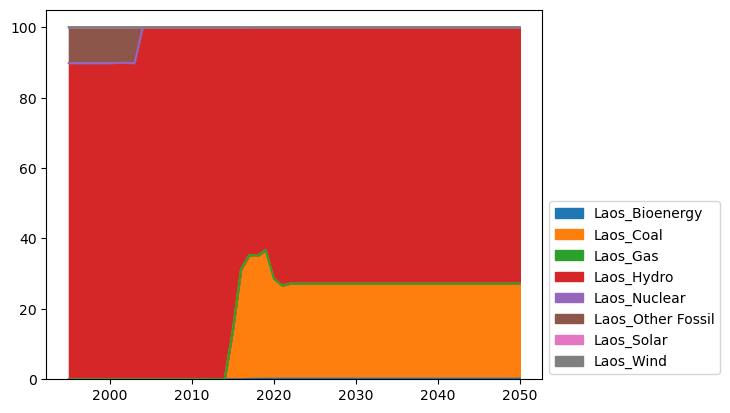

In [32]:
#emberdata_vars_perc_rename['Area'].unique()
areaofinterest = 'Laos'
gridmix_bycountry_1995to2050_full.filter(like=areaofinterest).plot(kind='area', legend='reverse').legend(bbox_to_anchor=(1, 0.5))

In [31]:
gridmix_bycountry_1995to2050_full.to_csv(os.path.join(baselinesFolder,'CarbonLayer','baseline_countrygridmix.csv'))